### Imports 

In [3]:
import numpy as np
import pandas as pd
import json
#from dscribe.descriptors import CoulombMatrix
from ase import Atoms
import matplotlib.pyplot as plt
import matplotlib
font = {'size'   : 22}

matplotlib.rc('font', **font)



In [4]:
def pad_with(vector, pad_width, iaxis, kwargs):
     pad_value = kwargs.get('padder', 10)
     vector[:pad_width[0]] = pad_value
     vector[-pad_width[1]:] = pad_value


def coulomb_matrix(atoms, n_atoms_max):
    # Creating a matrix with the product of the atomic numbers such that M_ij = Z[i]*Z[j]
    atomic_numbers = np.outer(atoms.get_atomic_numbers(),atoms.get_atomic_numbers())
    # Getting the distance matrix of the atoms object, such that element D_ij = |r_i - r_j|
    distances = atoms.get_all_distances()
    # Setting the diagonal elements, which are all zero, to 1 to avoid overflow errors
    np.fill_diagonal(distances, 1)
    
    # Creating the Cmat
    cmat = np.multiply(atomic_numbers, 1/distances) # Element wise multiplication
    np.fill_diagonal(cmat, 0.5*np.array(atoms.get_atomic_numbers())**2.4) # Filling the diagonal as described in the slides
    
    # Taking the sorted eigenvalues and padding with zeros such that all of the fingerprints have the same size
    shape = cmat.shape
    cmat,_ = np.linalg.eig(cmat)
    cmat = np.flip(np.sort(cmat))
    holder = np.zeros(n_atoms_max)
    holder[:shape[0]] = cmat
    cmat = holder
    
    return cmat



## Loading data and setting up the data frames

In [5]:
data_dir = "" # Specify your data path (Folder in which the files are placed)

In [6]:
# Loading the data as pandas DataFrame
train = pd.DataFrame(json.load(open(data_dir + "train.json", "rb")))
test = pd.DataFrame(json.load(open(data_dir + "test.json", "rb")))
## Transform atoms entry to ASE atoms object
train.atoms = train.atoms.apply(lambda x: Atoms(**x)) # OBS This one is important!
test.atoms = test.atoms.apply(lambda x: Atoms(**x))

In [10]:
print('Train data shape: {}'.format(train.shape))
train.head()

Train data shape: (2028, 5)


,formula,etot,dynamic_stability_level,atoms,Voigt_modulus
0,W2S2,-31.329664,1,"(Atom('W', [1.52711328, 0.8816792633, 9.115147...",80.175958
1,NiI2,-9.774512,2,"(Atom('Ni', [-7.814021732e-19, -1.673235808e-1...",31.358817
2,Ti3F2N2,-55.546656,1,"(Atom('Ti', [0.0, 0.0, 11.208358341], index=0)...",155.068663
3,Hf4N3O2,-85.216280,3,"(Atom('Hf', [0.0, 1.8605461437, 11.1322923235]...",279.073400
4,NbSTe,-19.876790,1,"(Atom('Nb', [1.26844161e-17, -3.001405002e-18,...",55.639070


In [13]:
train.atoms[1]

Atoms(symbols='NiI2', pbc=[True, True, False], cell=[[3.8508521418, -5.484107923e-19, 0.0], [-1.9254260709, 3.3349357811, 0.0], [1.332689519e-18, 0.0, 18.3890325946]])

In [17]:
print('Test data shape: {}'.format(test.shape))
test.head()

Test data shape: (264, 3)


,formula,etot,atoms
0,Ti2Te2,-21.567884,"(Atom('Te', [0.0001635792, 0.0005756553, 7.369..."
1,Cu2O2,-19.429111,"(Atom('Cu', [-3.606786318e-18, -0.0002926462, ..."
2,Y3C2,-33.214554,"(Atom('Y', [3.531761251e-18, -5.785592543e-18,..."
3,Ti2O4,-51.580206,"(Atom('Ti', [1.135647763e-19, 0.0301387729, 8...."
4,BiMoAs,-19.967820,"(Atom('Mo', [6.983934515e-18, 2.357780987e-16,..."


In [18]:
test.atoms[1]

Atoms(symbols='CuOCuO', pbc=[True, True, False], cell=[[2.8049685284, 1.734570062e-17, 0.0], [-3.746612841e-17, 5.602487274, 0.0], [-7.217855535e-18, 0.0, 16.9711719]])

In [19]:
np.unique(train.dynamic_stability_level,return_counts=True)

(array([1, 2, 3], dtype=int64), array([ 469,  538, 1021], dtype=int64))

## Creating the Coulomb matrix fingerprint
#### First a preprocessing step

In [20]:
species = []
number_of_atoms = []
atomic_numbers = []
for atom in pd.concat([train.atoms,test.atoms]):
    species = list(set(species+atom.get_chemical_symbols()))
    atomic_numbers = list(set(atomic_numbers+list(atom.get_atomic_numbers())))
    number_of_atoms.append(atom.get_number_of_atoms())

max_number_of_atoms = np.max(number_of_atoms)
min_atomic_number = np.min(atomic_numbers)
max_atomic_number = np.max(atomic_numbers)

print(max_number_of_atoms)

12


C:\software\anoconda\lib\site-packages\ase\atoms.py:971: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  warnings.warn('Use get_global_number_of_atoms() instead',


#### Coulomb matrix

In [21]:
cmats = np.zeros((len(train),max_number_of_atoms))
for i,atoms in enumerate(train.atoms):
    if i%1000 == 0:
        print(i)
    cmat = coulomb_matrix(atoms,max_number_of_atoms)
    cmats[i,:] = cmat.flatten()
print(len(cmats))

0
1000
2000
2028


In [22]:
cmat.shape

(12,)

In [25]:
print(len(cmats), cmats.shape)

2028 (2028, 12)


# Setting target and feature vector

In [26]:
X = pd.DataFrame(data = cmats, index=train.index)
y = train['Voigt_modulus']
print('X: {}'.format(X.shape))
print('y: {}'.format(y.shape))

X: (2028, 12)
y: (2028,)


## Splitting into test and train set

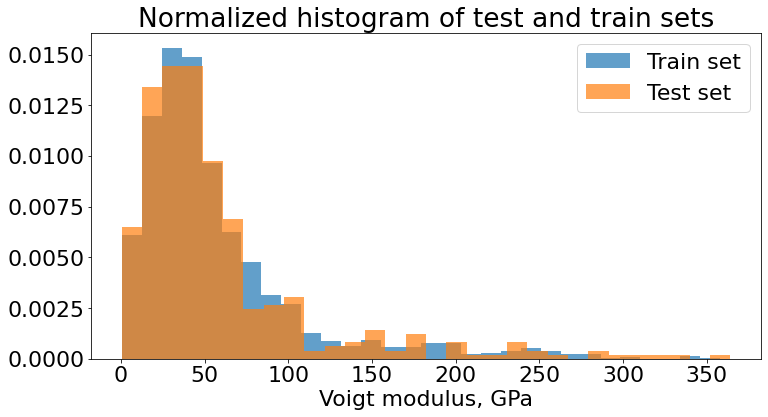

In [27]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=250)

plt.figure(figsize = (12, 6))
plt.hist(y_train, bins=30, alpha=0.7, density=True, label='Train set')
plt.hist(y_test, bins=30, alpha=0.7, density=True, label='Test set')

plt.title("Normalized histogram of test and train sets")
plt.xlabel("Voigt modulus, GPa")
plt.legend()
plt.show()


# Sklearn Ridge Regression model

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

In [29]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [30]:
model = LinearRegression()
model.fit(X=X_train,y=y_train)

LinearRegression()

In [31]:
train_prediction = model.predict(X_train)
train_prediction

array([49.33329846, 60.00861102, 68.91229728, ..., 52.02813643,
       28.71882505, 52.91108475])

In [32]:
test_prediction = model.predict(X_test)

In [33]:
print('Train RMSE = {:.2f}'.format(rmse(y_train,train_prediction)))
print('Test RMSE = {:.2f}'.format(rmse(y_test,test_prediction)))

Train RMSE = 49.01
Test RMSE = 53.21


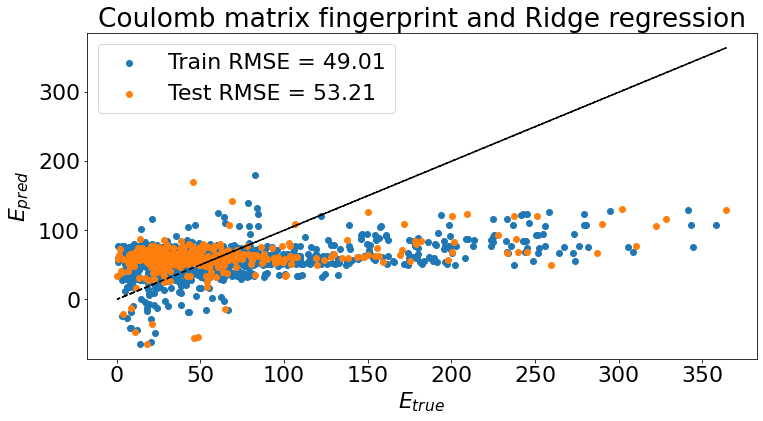

In [34]:
fig = plt.figure(figsize = (12, 6))

plt.title("Coulomb matrix fingerprint and Ridge regression")
plt.scatter(y_train, model.predict(X_train), label = 'Train RMSE = {:.2f}'.format(rmse(y_train,train_prediction)))
plt.scatter(y_test, model.predict(X_test), label = 'Test RMSE = {:.2f}'.format(rmse(y_test,test_prediction)))
plt.plot(y_test, y_test, linestyle = "--", color = "k")
plt.xlabel("$E_{true}$")
plt.ylabel("$E_{pred}$")
plt.legend()
plt.show()

# Prepare submission to Kaggle

In [35]:
cmats_test = np.zeros((len(test),max_number_of_atoms))
for i,atoms in enumerate(test.atoms):
    if i%1000 == 0:
        print(i)
    cmat = coulomb_matrix(atoms,max_number_of_atoms)
    cmats_test[i,:] = cmat.flatten()
print(len(cmats))

0
2028


In [37]:
X_test_kaggle = pd.DataFrame(data = cmats_test, index=test.index)
X_test_kaggle.loc[:,:] = scaler.transform(X_test_kaggle)
X_test_kaggle.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.264996,0.074604,-0.460627,-0.261803,-0.348874,-0.341228,-0.222658,-0.219649,-0.119769,-0.108089,-0.072916,-0.070458
1,-1.047995,-0.802926,-0.781811,-0.558085,-0.348874,-0.341228,-0.222658,-0.219649,-0.119769,-0.108089,-0.072916,-0.070458
2,-0.729358,-0.488713,0.283214,-0.561561,-0.328414,-0.341228,-0.222658,-0.219649,-0.119769,-0.108089,-0.072916,-0.070458
3,-1.174855,-0.930474,-0.777343,-0.553492,-0.304618,-0.304297,-0.222658,-0.219649,-0.119769,-0.108089,-0.072916,-0.070458
4,1.652167,-0.306347,-0.009804,-0.580001,-0.348874,-0.341228,-0.222658,-0.219649,-0.119769,-0.108089,-0.072916,-0.070458


In [39]:
test_prediction_dataframe = pd.DataFrame(data = {'ID':test.index,
                                                 'Voigt_modulus':model.predict(X_test_kaggle)})
test_prediction_dataframe.head()

,ID,Voigt_modulus
0,0,59.859728
1,1,58.900576
2,2,71.665732
3,3,59.644397
4,4,41.461609


In [40]:
test_prediction_dataframe.to_csv(data_dir+'submission_test.csv',index=False)